In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime
import json
from tqdm import tqdm

In [12]:
L = 50
u = 0.0001
k1 = 1
k2 = 0.04
eps = 0.01  
alpha = 0.1
F0 = 1
m = 1
h = 0.1
eps2 = 0.007     

In [10]:
@njit 
def sum2(a):
    sh = a.shape[0]
    b =  np.zeros(sh)
    b[0] = a[0]
    for i in range(1,sh):
        b[i] = b[i-1] + a[i]

    return b


@njit
def f(x,v,t,l,alpha):
     k2= 1/(l-1)
     
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))


@njit
def acc(x,v,t,l,alpha):
    k2= 1/(l-1)
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t,l,alpha) )/m



@njit
def tenstion(x,v,t,l,alpha):
    return m*acc(x,v,t,l,alpha) + f(x,v,t,l,alpha)


@njit
def step(x,v,t,l,alpha):
    k2= 1/(l-1)

    if np.all(v==0):
        t += (F0-np.max(tenstion(x,v,t,l,alpha)))/(k2*u)


        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)
        

    else: 
        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)

    return x, v,t+h

@njit(cache=True)
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out


@njit
def run(x,v,t,steps,l,alpha):
    xdata = np.zeros((steps,l),dtype=np.float64)
    vdata = np.zeros((steps,l),dtype=np.float64)
    tenstionData = np.zeros((steps,l),dtype=np.float64)
    for i in range(steps):
        x,v,t = step(x,v,t,l,alpha)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t,l,alpha)

    slipping = np_any_axis1(vdata>0)

    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)

    slippingR[0] = False
    slippingL[-1] = False 

    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))

    totalX = np.sum(xdata,axis = 1)

    eventsSize = totalX[np.argwhere(ends)[:,0]] - totalX[np.argwhere(starts)[:,0]]
    eventsBlocks = np.sum(xdata[ends]!=xdata[starts],axis=1).reshape(-1,1)



    arr1 = vdata>0
    arr2 = arr1 > np.roll(arr1,1)
    arr3 = np.sum(arr2,axis=1)
    arr4 = sum2(arr3)

    arr5 = arr4[np.argwhere(starts)[:,0]]
    arr6 = arr4[np.argwhere(ends)[:,0]]

    eventsBlocks2 = arr6-arr5


    return x,v,t,eventsSize,eventsBlocks,eventsBlocks2,xdata,vdata,ends,tenstionData


In [26]:
np.loadtxt("dist_l=1.txt")

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
import threading


def print_cube(num):
    print("Cube: {}" .format(num * num * num))


def print_square(num):
    print("Square: {}" .format(num * num))


if __name__ =="__main__":
    t1 = threading.Thread(target=print_square, args=(10,))
    t2 = threading.Thread(target=print_cube, args=(10,))

    t1.start()
    t2.start()

    t1.join()
    t2.join()

    print("Done!")

# trying different alphas:

In [21]:
alphas = np.array([10**i for i in range(-5,5)])

In [33]:
for alpha in alphas:
    x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
    v = np.zeros(L,dtype=np.float64)
    t = 0
    x,v,t,eventsSize,eventsBlocks,eventsBlocks2,xdata,vdata,ends,tenstionData = run(x,v,t,1_000_000,L,alpha)
    Ts = tenstionData[ends][np.argwhere(eventsBlocks[:] >= 50)[:,0]]
    np.save("TsForAlpha="+str(alpha),Ts)
    print(alpha)

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


In [ ]:
Ts = np.load("TsForAlpha=10000.0.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=1000.0.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=100.0.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=10.0.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()


Ts = np.load("TsForAlpha=1.0.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=0.1.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()


Ts = np.load("TsForAlpha=0.01.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=0.001.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=0.0001.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

Ts = np.load("TsForAlpha=1e-05.npy")
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()
plt.bar(np.arange(50),np.mean(Ts,axis=0))
plt.show()

# Tension Data 

In [13]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
v = np.zeros(L,dtype=np.float64)
t = 0
x,v,t,eventsSize,eventsBlocks,eventsBlocks2,xdata,vdata,ends,tenstionData = run(x,v,t,1_000_000,L,1)


/tmp/ipykernel_33823/1043351592.py:103: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  x,v,t = step(x,v,t,l,alpha)


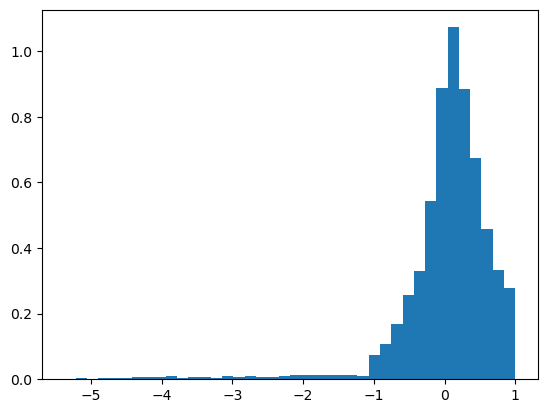

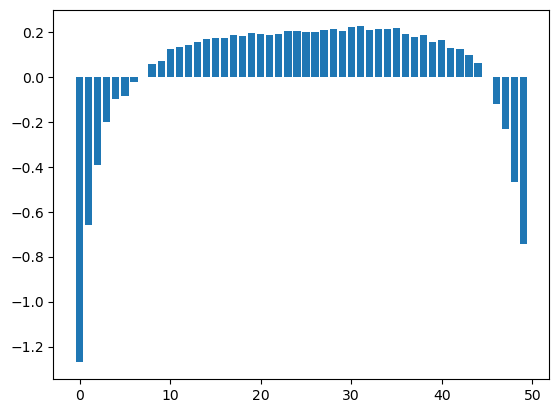

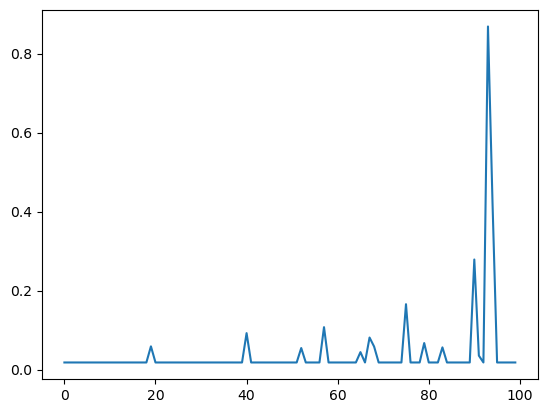

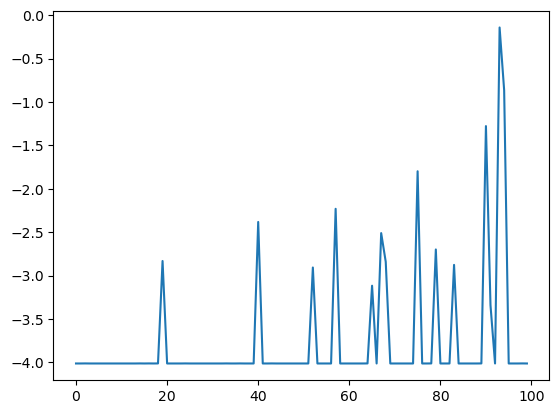

In [29]:
Ts = tenstionData[ends][np.argwhere(eventsBlocks2[:] >= 500)[:,0]]
plt.hist(Ts.reshape(-1),bins= 40,density=True)
plt.show()


plt.bar(np.arange(L),np.mean(Ts,axis=0))
plt.show()

plt.plot(np.arange(100),eventsSize[:100])
plt.show()

plt.plot(np.arange(100),np.log(eventsSize[:100]))
plt.show()

# TsData 

In [ ]:
TsData= np.array([]).reshape((-1,50))

for _ in tqdm(range(2000)):
    x,v,t,eventsSize,eventsBlocks,eventsBlocks2,xdata,vdata,ends,tenstionData = run(x,v,t,1_000_000,L,alpha)
    Ts = tenstionData[ends][np.argwhere(eventsBlocks2[:] >= 500)[:,0]]
    TsData = np.concatenate([TsData,Ts],axis = 0)


np.save(f"TsDataAlpha={alpha},L={L}",TsData)


# P_l_(l,t)

In [ ]:

h = 0.01
minimum = np.min(Tsdata) - 10 *h
steps = np.round((1 - minimum)/h).astype(np.int64)
p_l_t_data = np.zeros((steps,L))

thersold_by_time = 1
for i in range(steps):
    is_above = TsData >= thersold_by_time 

    is_above_R = np.roll(is_above,+1,axis=1)
    is_above_L = np.roll(is_above,-1,axis=1)

    is_above_R[:,0] = False
    is_above_L[:,-1] = False 

    is_above_ends  = np.logical_xor( is_above ,(is_above *is_above_L))
    is_above_starts  = np.logical_xor( is_above ,(is_above * is_above_R))
    # lengths = np.argwhere(is_above_ends) - np.argwhere(is_above_starts) 
    lengths = np.nonzero(is_above_ends)[1] - np.nonzero(is_above_starts)[1]
    # p_l_t_data[i,lengths[:,0]] += 1

    for length in lengths:
        p_l_t_data[i,length] += 1

    thersold_by_time -= h

    print(i)


np.save(f"p_l_t_data={alpha},L={L}",p_l_t_data)


In [ ]:
plt.plot(np.arange(L),p_l_t_data[50])
plt.show()

plt.plot(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data,axis=0)))
plt.show()

print(scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:step],axis=0))))


for i in range(1,L):
    step = i
    plt.plot(np.log(np.arange(1,L+1)),np.log(p_l_t_data[step]))
plt.show()

step = 50
plt.plot(np.arange(L),p_l_t_data[step])
plt.show()
plt.plot(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:100],axis=0)))
scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:50],axis=0)))


# trying for different Ls 

In [31]:
ls = np.array(np.exp(np.arange(4,6,0.1)),dtype = np.int64)
ls.shape,ls

((20,),
 array([ 54,  60,  66,  73,  81,  90,  99, 109, 121, 134, 148, 164, 181,
        200, 221, 244, 270, 298, 330, 365]))

In [21]:
ls = np.array(np.exp(np.arange(4,6,0.1)),dtype = np.int64)
means1 = np.zeros_like(ls)
means2 = np.zeros_like(ls)
means3 = np.zeros_like(ls)

var1 = np.zeros_like(ls)
var2 = np.zeros_like(ls)
var3 = np.zeros_like(ls)

for i in range(ls.shape[0]):

    l = ls[i]

    x = 0.1*np.random.uniform(-1,1,l).astype(dtype=np.float64) 
    v = np.zeros(l,dtype=np.float64)
    t = 0


    for _ in tqdm(range(30)):
        x,v,t,eventsSize,eventsBlocks,eventsBlocks2= run(x,v,t,1_000_000,l)

        means1[i] += np.mean(eventsSize)
        means2[i] += np.mean(eventsBlocks)
        means3[i] += np.mean(eventsBlocks2)


    
    print(i)

    

100%|██████████| 30/30 [07:08<00:00, 14.27s/it]


0


100%|██████████| 30/30 [07:08<00:00, 14.29s/it]


1


100%|██████████| 30/30 [07:22<00:00, 14.74s/it]


2


100%|██████████| 30/30 [07:59<00:00, 16.00s/it]


3


100%|██████████| 30/30 [09:15<00:00, 18.51s/it]


4


100%|██████████| 30/30 [09:56<00:00, 19.88s/it]


5


100%|██████████| 30/30 [09:36<00:00, 19.21s/it]


6


100%|██████████| 30/30 [10:12<00:00, 20.41s/it]


7


100%|██████████| 30/30 [12:11<00:00, 24.39s/it]


8


100%|██████████| 30/30 [13:04<00:00, 26.15s/it]


9


100%|██████████| 30/30 [14:24<00:00, 28.82s/it]


10


100%|██████████| 30/30 [16:02<00:00, 32.09s/it]


11


100%|██████████| 30/30 [16:56<00:00, 33.88s/it]


12


100%|██████████| 30/30 [18:26<00:00, 36.89s/it]


13


100%|██████████| 30/30 [20:08<00:00, 40.27s/it]


14


100%|██████████| 30/30 [21:15<00:00, 42.53s/it]


15


100%|██████████| 30/30 [24:01<00:00, 48.05s/it]


16


100%|██████████| 30/30 [26:19<00:00, 52.64s/it]


17


100%|██████████| 30/30 [28:34<00:00, 57.15s/it]


18


100%|██████████| 30/30 [31:06<00:00, 62.20s/it]

19


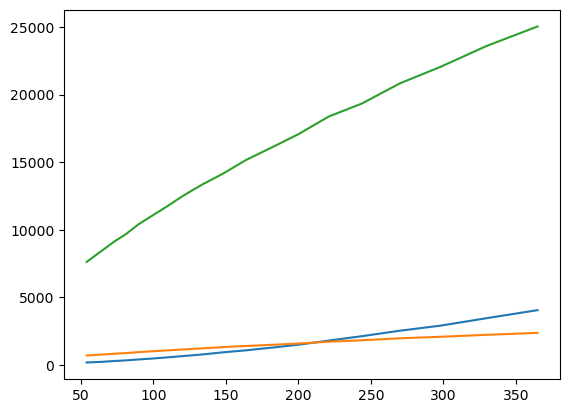

In [22]:
plt.plot(ls,means1)
plt.plot(ls,means2)
plt.plot(ls,means3)

plt.show()

plt.plot(np.log(ls),np.log(means1))
plt.plot(np.log(ls),np.log(means2))
plt.plot(np.log(ls),np.log(means3))

plt.show()

print(scipy.stats.linregress(np.log(ls),np.log(means1)))

print(scipy.stats.linregress(np.log(ls),np.log(means2)))

print(scipy.stats.linregress(np.log(ls),np.log(means3)))

# parts close to thersold (1-eps2)

In [ ]:
dataDic1 = {}
dataDic2 = {}
dataDic3 = {}

for i in range(0,L+1):
    dataDic1[i] = []
    dataDic2[i] = []
    dataDic3[i] = []

In [19]:
for j in range(400):
    x,v,t,eventsSize,eventsBlocks,eventsBlocks2,ls= run(x,v,t,5_000_000)

    # time = str(datetime.datetime.now())
    
    # np.save("eventsSize-"+time,eventsSize)
    # np.save("eventsBlocks-"+time,eventsBlocks)
    # np.save("eventsBlocks2-"+time,eventsBlocks2)
    # np.save("ls-"+time,ls)

    for i in range(eventsSize.shape[0]):
        dataDic1[int(ls[i])].append(float(eventsSize[i]))
        dataDic2[int(ls[i])].append(float(eventsBlocks[i]))
        dataDic3[int(ls[i])].append(float(eventsBlocks2[i]))

    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [186]:
num = 0
for i in list(dataDic1.values()):
    num += len(i)

print(num)

10022148


In [21]:

with open("dataDics6_1.json", "w") as outfile: 
    json.dump(dataDic1, outfile)

with open("dataDics6_2.json", "w") as outfile: 
    json.dump(dataDic2, outfile)

with open("dataDics6_3.json", "w") as outfile: 
    json.dump(dataDic3, outfile)

In [185]:
with open('dataDics6_1.json') as json_data:
    dataDic1 = json.load(json_data)
    json_data.close()

with open('dataDics6_2.json') as json_data:
    dataDic2 = json.load(json_data)
    json_data.close()


with open('dataDics6_3.json') as json_data:
    dataDic3 = json.load(json_data)
    json_data.close()

In [187]:
means1 = np.zeros(L+1)
vars1 = np.zeros(L+1)

means2 = np.zeros(L+1)
vars2 = np.zeros(L+1)

means3 = np.zeros(L+1)
vars3 = np.zeros(L+1)

for i in range(L+1):
    means1[i] = np.mean(dataDic1[str(i)])
    vars1[i]=  np.var(dataDic1[str(i)])

    means2[i] = np.mean(dataDic2[str(i)])
    vars2[i]=  np.var(dataDic2[str(i)])

    means3[i] = np.mean(dataDic3[str(i)])
    vars3[i]=  np.var(dataDic3[str(i)])
    


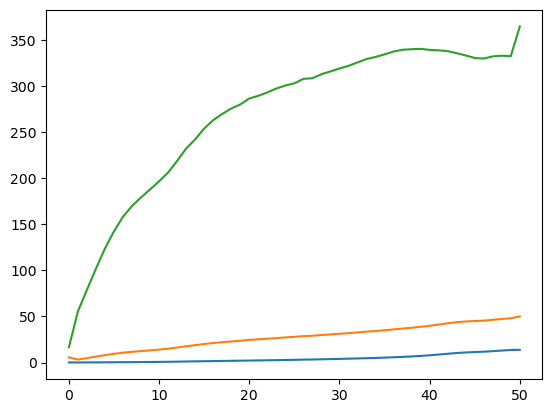

In [188]:
plt.plot(np.arange(L+1),means1)
plt.plot(np.arange(L+1),means2)
plt.plot(np.arange(L+1),means3)

/tmp/ipykernel_33823/646502187.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(np.arange(L+1)),np.log(means1))
/tmp/ipykernel_33823/646502187.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(np.arange(L+1)),np.log(means2))
/tmp/ipykernel_33823/646502187.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(np.arange(L+1)),np.log(means3))


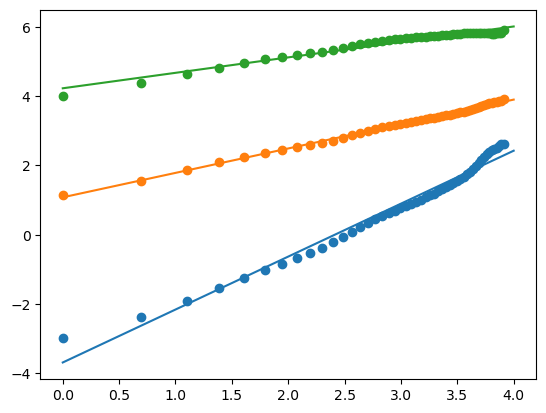

In [189]:
plt.scatter(np.log(np.arange(L+1)),np.log(means1))
plt.scatter(np.log(np.arange(L+1)),np.log(means2))
plt.scatter(np.log(np.arange(L+1)),np.log(means3))

s1,i1,_,_,_ = scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(means1[1:]))
s2,i2,_,_,_ = scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(means2[1:]))
s3,i3,_,_,_ = scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(means3[1:]))

plt.plot([0,4],[i1,i1+4*s1])
plt.plot([0,4],[i2,i2+4*s2])
plt.plot([0,4],[i3,i3+4*s3])

In [190]:
print(scipy.stats.linregress(np.log(np.arange(1,21)),np.log(means1[1:21])))
print(scipy.stats.linregress(np.log(np.arange(1,21)),np.log(means2[1:21])))
print(scipy.stats.linregress(np.log(np.arange(1,21)),np.log(means3[1:21])))

LinregressResult(slope=1.306649052469282, intercept=-3.2683115041606285, rvalue=0.9943350735555948, pvalue=5.590183682534151e-19, stderr=0.032921995235396254, intercept_stderr=0.07440835568528668)
LinregressResult(slope=0.6876975122734633, intercept=1.1146525218839045, rvalue=0.9984431781405178, pvalue=5.07294858173191e-24, stderr=0.009055307640957695, intercept_stderr=0.02046627329146944)
LinregressResult(slope=0.5526080393638697, intercept=4.0281864442380115, rvalue=0.9986686136122446, pvalue=1.2422238282512795e-24, stderr=0.006727938263512038, intercept_stderr=0.01520609002463542)


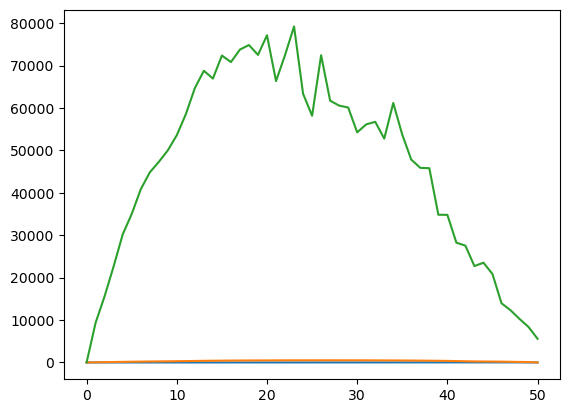

In [193]:
plt.plot(np.arange(L+1),vars1)
plt.plot(np.arange(L+1),vars2)
plt.plot(np.arange(L+1),vars3)

In [ ]:
for i in range(1,L+1):
    plt.title(i)
    fig = plt.Figure()
    ax = plt.gca()

    x,y = np.histogram(dataDic2.get(str(i)))
    y = ((np.roll(y,-1) + y)/2)[:-1]
    ax.scatter(y,x)
    ax.set_yscale("log")
    plt.show()

In [ ]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic2[i],log=True)
    plt.show()

In [ ]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic1[i],log=False)
    plt.show()

In [ ]:
for i in range(L+1):
    plt.title(i)
    plt.hist(dataDic3[i],log=False)
    plt.show()

<BarContainer object of 15 artists>

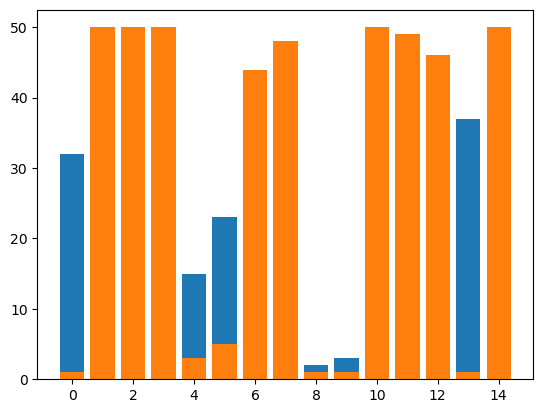

In [142]:
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])

plt.show()

plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])

plt.show()


# p_size_(size,blocks)

In [114]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float64) 
v = np.zeros(L,dtype=np.float64)
t = 0

parts = 100
steps = 1_000_000
eventsSizes = np.array([])
eventsBlocks = np.array([]).reshape((0,1))
for p in range(parts):
    x,v,t,eventsSize,eventsBlock,_ = run(x,v,t,steps)
    eventsSizes = np.concatenate((eventsSizes,eventsSize))
    eventsBlocks = np.concatenate((eventsBlocks,eventsBlock))
    print(p)    

dists = []
for i in range(L):
    dists.append(eventsSizes[(eventsBlocks==i)[:,0]])


distsMean = np.zeros(L)
distsVar = np.zeros(L)

for i in range(0,L):
    distsMean[i] = np.mean(dists[i])
    distsVar[i] = np.var(dists[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [132]:
plt.plot(np.arange(L),distsMean)
plt.show()

plt.plot(np.log(np.arange(1,L)),np.log(distsMean[1:]))
plt.show()

plt.plot(np.arange(L),distsVar)
plt.show()

print(scipy.stats.linregress(np.log(np.arange(1,L)),np.log(distsMean[1:])))

50

In [ ]:
for i in range(0,L):
    plt.title(i+1)
    plt.hist(dists[i])
    plt.show()

# p_size_(size)

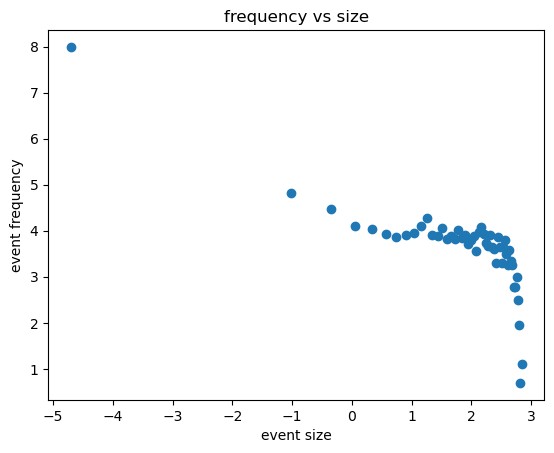

In [43]:
freq,size = np.histogram(eventsSize,bins=50)

#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

# Solving for one block 

In [155]:
u = 0.01
k1 = 1
k2 = 0.04
eps = 0.01  
alpha = 0.1
F0 = 1
m = 1
h = 0.0001
eps2 = 0.007    


@njit
def acc2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t - f2(x,v,t) )/m


@njit
def f2(x,v,t):
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2)+ k2*u*t) < F0, -x*(2*k1 + k2) + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))


@njit
def tenstion2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t )/m

@njit
def step2(x,v,t):
    k1 = v
    l1 = acc2(x,v,t)

    k2 = v + l1*h/2
    l2 = acc2(x+k1*h/2,v + l1*h/2,t + h/2)

    k3 = v + l2*h/2
    l3 = acc2(x+k2*h/2,v + l2*h/2,t + h/2)

    k4 = v + l3/2
    l4 = acc2(x+k3*h,v + l3*h, t + h)

    xNew = x +  (k1 + 2*k2 + 2*k3 + k4)*h/6
    vNew = v +  (l1 + 2*l2 + 2*l3 + l4)*h/6

    vNew = 0 if vNew < 0 else vNew 
    
    return xNew, vNew,t+h

In [179]:
x = 0
v = 0
t0 = 2450
t = t0 
steps = 1_000_000
xData = np.zeros(steps)
vData = np.zeros(steps)
ts = h*np.arange(steps)

In [180]:
for i in range(steps):
    xData[i] = x
    vData[i] = v
    x,v,t = step2(x,v,t)


tensionData= tenstion2(xData,vData,t0 + ts)
fData= f2(xData,vData,t0 + ts)

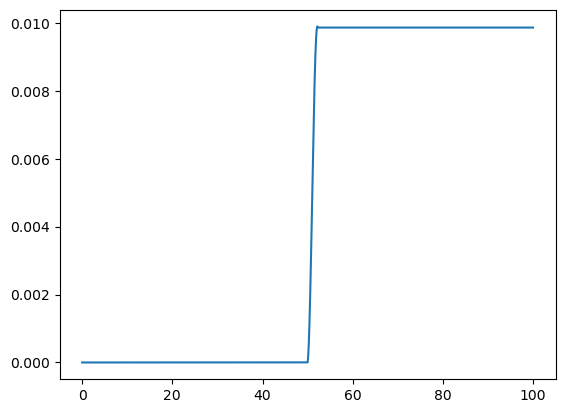

In [181]:
plt.plot(ts,xData)

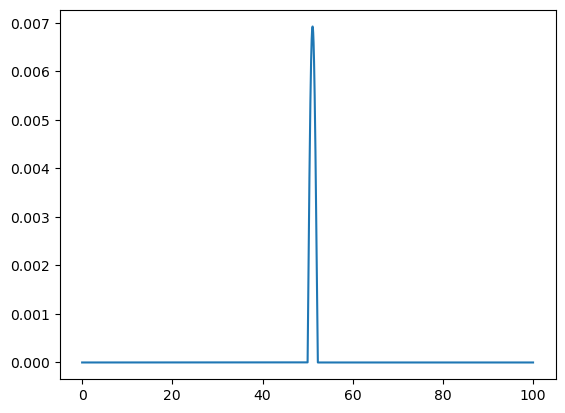

In [182]:
plt.plot(ts,vData)

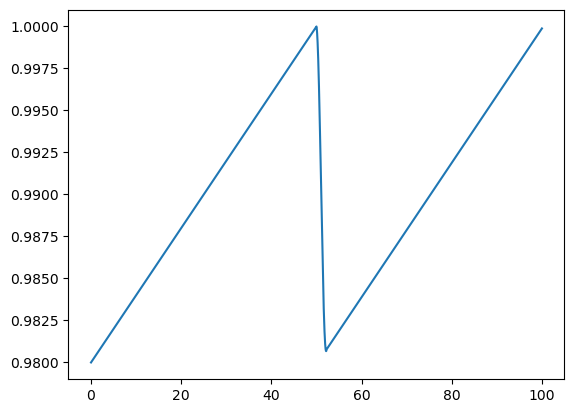

In [184]:
plt.plot(ts,tensionData)